Run this line of code first to import needed packages, run classes and functions. Make sure the db_utils Python file has been run before running this code.

In [27]:
import pandas as pd
import numpy as np
import missingno as msno
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from textwrap import wrap

def csv_to_df():
    loans_df = pd.read_csv('loan_payments.csv', index_col=0)
    return loans_df

class DataTransform:
    def __init__(self, df):
        self.df = df
    
    def map_columns(self):
        loan_status_mapping = {'Does not meet the credit policy. Status:Charged Off': 'Charged Off',
                               'Does not meet the credit policy. Status:Fully Paid': 'Fully Paid'}
        self.df['loan_status'] = self.df['loan_status'].replace(loan_status_mapping)

    def update_cols(self):
        self.df = self.df.astype({"loan_amount":'float64', 
                                  "issue_date":'datetime64[ns]',
                                  "earliest_credit_line":'datetime64[ns]',
                                  "last_payment_date":'datetime64[ns]',
                                  "next_payment_date":'datetime64[ns]',
                                  "last_credit_pull_date":'datetime64[ns]',
                                  "loan_status":'category', 
                                  "grade":'category', 
                                  "sub_grade":'category', 
                                  "home_ownership":'category',
                                  "verification_status":'category', 
                                  "payment_plan":'category', 
                                  "purpose":'category',
                                  "policy_code":'category',
                                  "application_type":'category'})
        return self.df

class DataFrameInfo:
    def __init__(self, df):
        self.df = df

    def data_types(self):
        print(self.df.dtypes)
    
    def stat_values(self):
        print(self.df.describe())
    
    def unique_count(self):
        print(self.df.nunique())

    def shape(self):
        print(self.df.shape)

    def null_count(self):
        null_df = self.df.isnull()
        print("Null count:")
        print(null_df.sum(), "\n")
        print("Null percentage count:")
        print((null_df.sum()/len(self.df))*100)

class DataFrameTransform:
    def __init__(self, df):
        self.df = df
    
    def drop_columns(self):
        new_df_cols = self.df.drop(labels=["mths_since_last_delinq","mths_since_last_record","next_payment_date","mths_since_last_major_derog"], axis=1)
        return new_df_cols

    def drop_rows(self, new_df):
        new_df.dropna(axis=0, subset=["last_payment_date", "last_credit_pull_date"], how="any", inplace=True)
        return new_df

    def impute_columns(self, new_df):
        new_df['funded_amount'].fillna((new_df['funded_amount'].mean()+new_df['funded_amount'].median())/2, inplace=True)
        new_df['term'].fillna("60 months", inplace=True)
        new_df['int_rate'].fillna(method="ffill", inplace=True)
        new_df['employment_length'].fillna(method="ffill", inplace=True)
        new_df['collections_12_mths_ex_med'].fillna(0, inplace=True)
        return new_df
    
    def log_transform(self, col):
        log_col = col.map(lambda i: np.log(i) if i > 0 else 0)
        return log_col
    
    def box_cox(self, col):
        transform_data, lambda_value = stats.boxcox(col)
        return transform_data  
    
    def yeo_johnson(self, col):
        transform_data, lambda_value = stats.yeojohnson(col)
        return transform_data
    
    def remove_outliers(self, cols):
        Q1 = self.df[cols].quantile(0.25)
        Q3 = self.df[cols].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        filtered = self.df[~((self.df[cols] < lower_bound) | (self.df[cols] > upper_bound)).any(axis=1)]
        return filtered

class Plotter:
    def __init__(self, df):
        self.df = df
    
    def matrix_plot(self):
        msno.matrix(self.df)
        plt.show()

    def hist_plot(self, col):
        sns.histplot(col,label="Skewness: %.2f"%(col.skew()), bins=20)
        plt.legend()
        plt.show()

    def qq_plot(self, col):
        qq_plot = qqplot(col , scale=1 ,line='q', fit=True)
        plt.show()

    def box_plot(self,col):
        plt.figure()
        sns.boxplot(col, showfliers=True)
        plt.show()

This code imports the csv file created within db_utils and converts all possible columns to the correct datatype (e.g. objects to times and categories and integers to floats).

In [28]:
pd.set_option('display.max_columns', None)
old_loans_df = csv_to_df()
loans_df = DataTransform(old_loans_df)
loans_df.map_columns()
loans_df = loans_df.update_cols()

C:\Users\megan\AppData\Local\Temp\ipykernel_7892\926889140.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df = self.df.astype({"loan_amount":'float64',
C:\Users\megan\AppData\Local\Temp\ipykernel_7892\926889140.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df = self.df.astype({"loan_amount":'float64',
C:\Users\megan\AppData\Local\Temp\ipykernel_7892\926889140.py:24: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  self.df = self.df.astype({"loan_amount":'float64',
C:\Users\megan\AppData\Local\Temp\ipykernel_7892\926889140.py:24: UserWarning: Could not in

Drops any columns that have a percentage of NaN's higher than 50% and imputes all other columns that have NaN's with either a combination of the mean and median, using the ffill function to fill in NaN's with the next closest value in the dataset or dropping the row entirely if the column has a small number of NaN's that can't be imputed (e.g. a date). Also updates the "term" column now that the NaNs have been removed.

In [29]:
new_loans = DataFrameTransform(loans_df)
dropped_cols_loans = new_loans.drop_columns()
dropped_rows_loans = new_loans.drop_rows(dropped_cols_loans)
updated_loans = new_loans.impute_columns(dropped_rows_loans)
updated_loans["term"] = updated_loans["term"].map({"60 months": 60, "36 months": 36})
updated_loans = updated_loans.astype({"term":'int64'})

C:\Users\megan\AppData\Local\Temp\ipykernel_7892\926889140.py:79: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_df['int_rate'].fillna(method="ffill", inplace=True)
C:\Users\megan\AppData\Local\Temp\ipykernel_7892\926889140.py:80: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_df['employment_length'].fillna(method="ffill", inplace=True)


Shows the null count and percentage null count before and after applying the above code

In [30]:
loans_info = DataFrameInfo(loans_df)
print("Nulls before NaN removal and imputation:")
loans_info.null_count()
updated_loans_info = DataFrameInfo(updated_loans)
print("Nulls after NaN removal and imputation:")
updated_loans_info.null_count()

Nulls before NaN removal and imputation:
Null count:
id                                 0
member_id                          0
loan_amount                        0
funded_amount                   3007
funded_amount_inv                  0
term                            4772
int_rate                        5169
instalment                         0
grade                              0
sub_grade                          0
employment_length               2118
home_ownership                     0
annual_inc                         0
verification_status                0
issue_date                         0
loan_status                        0
payment_plan                       0
purpose                            0
dti                                0
delinq_2yrs                        0
earliest_credit_line               0
inq_last_6mths                     0
mths_since_last_delinq         31002
mths_since_last_record         48050
open_accounts                      0
total_accounts        

Creates a matrix plot to show the distibution of nulls before and after the dataframetransform is applied to show all nulls are either removed or imputed.

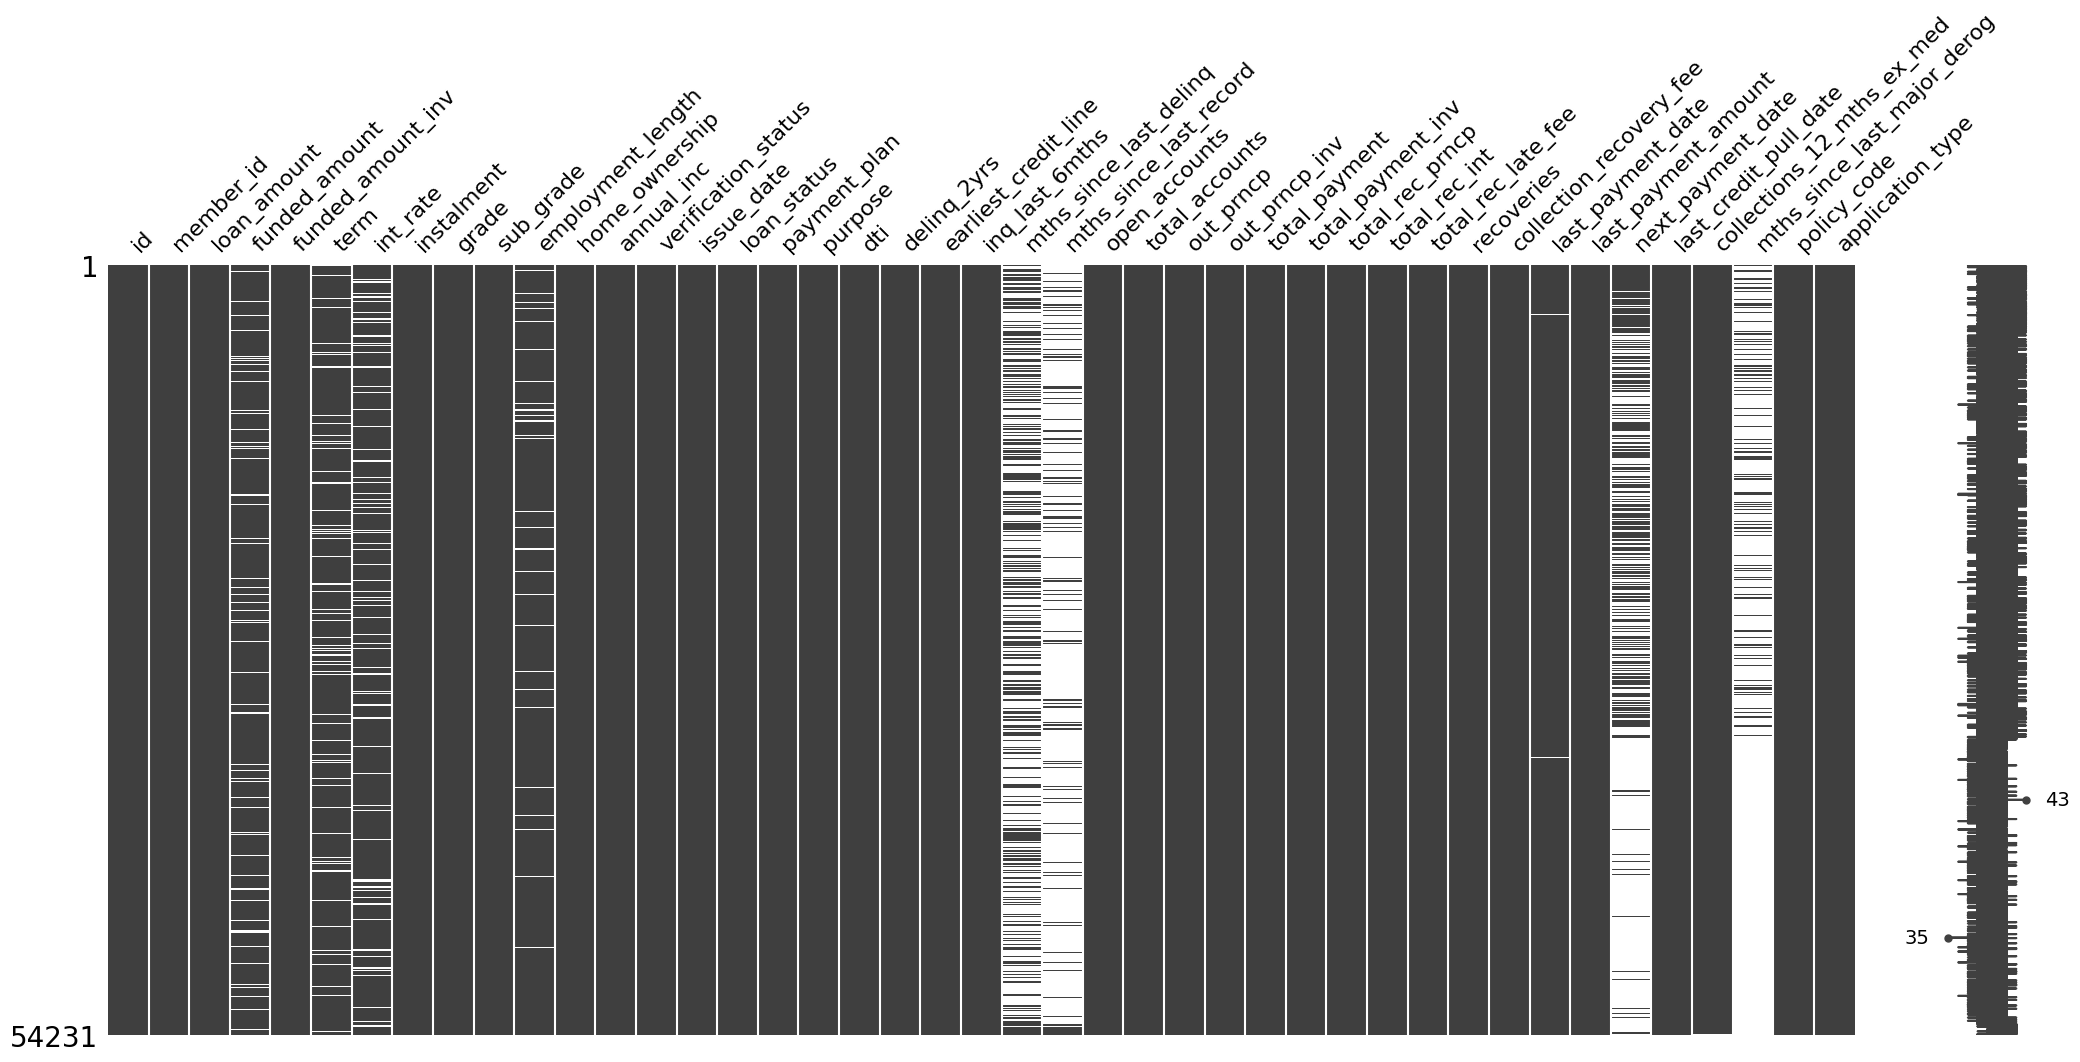

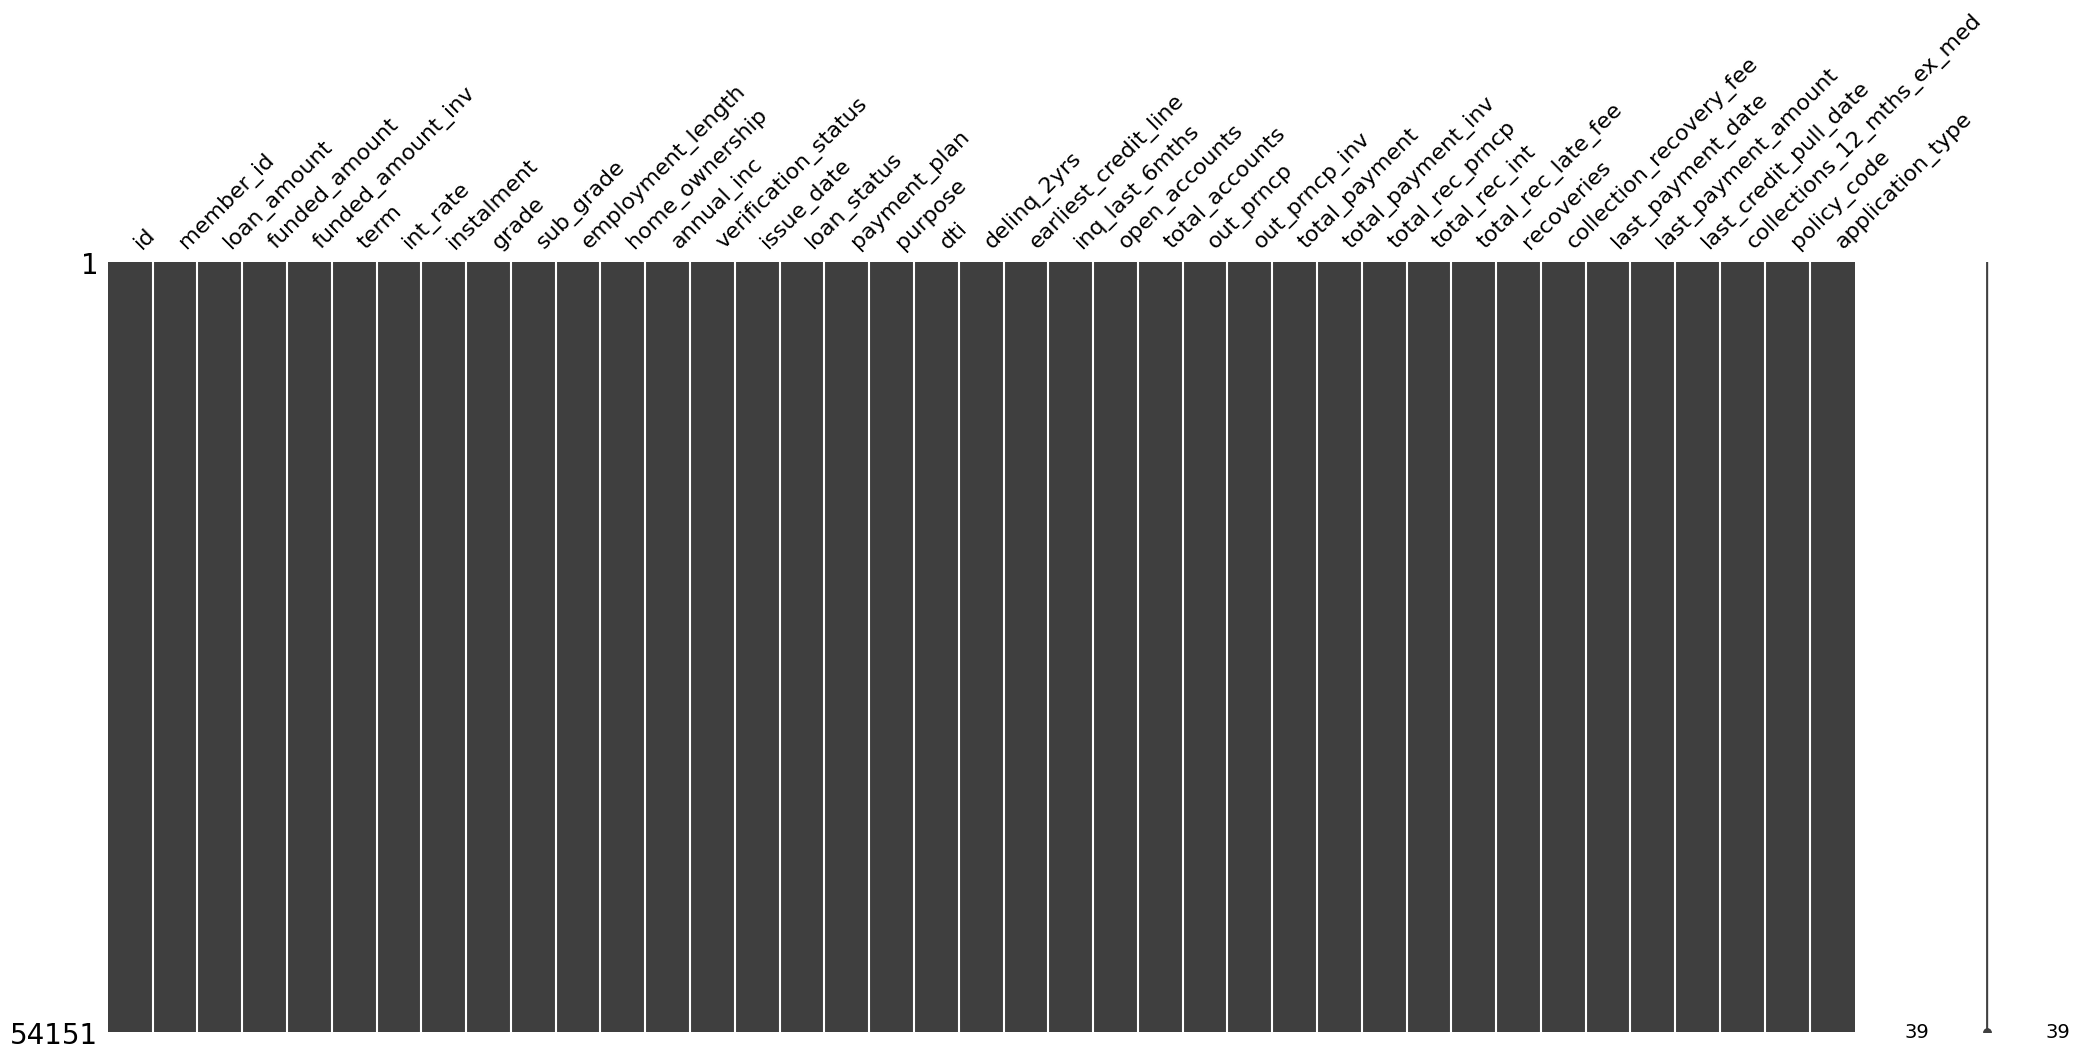

In [31]:
loans_plot = Plotter(loans_df)
loans_plot.matrix_plot()
updated_loans_plot = Plotter(updated_loans)
updated_loans_plot.matrix_plot()

Changes skew on any columns that have a skew value above 2 or below -2. Uses either a log, box cox or yeo johnson transform, depending on the data. The transform used is simply the one that gives the best reduction (closest to 0) in skew. Also shows a histogram of the column "annual_inc" before and after altering the skew, with the skew of the data displayed in the top right.

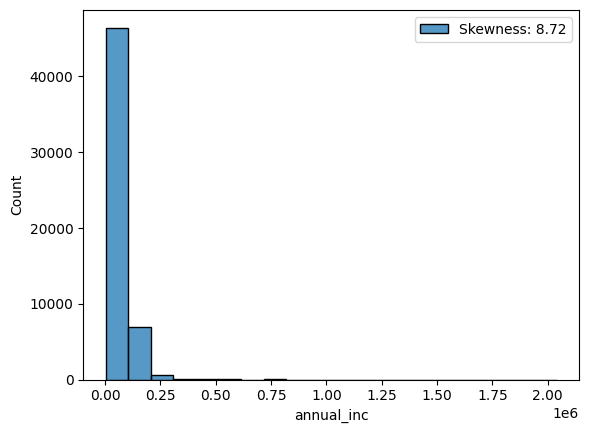

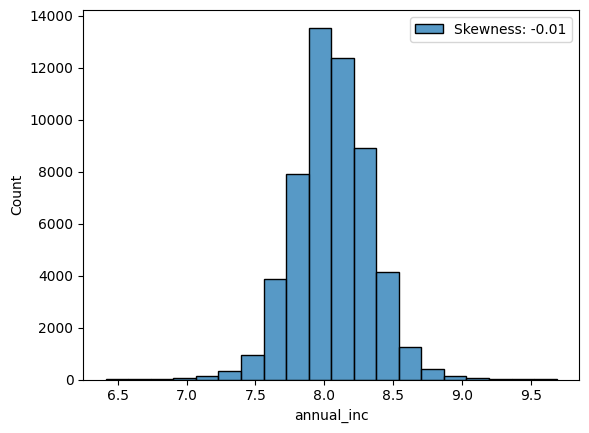

In [32]:
updated_loans_plot.hist_plot(updated_loans['annual_inc'])
data_transform = DataFrameTransform(updated_loans)
updated_loans['annual_inc'] = data_transform.box_cox(updated_loans['annual_inc'])
updated_loans['delinq_2yrs'] = data_transform.yeo_johnson(updated_loans['delinq_2yrs'])
updated_loans['inq_last_6mths'] = data_transform.yeo_johnson(updated_loans['inq_last_6mths'])
updated_loans['out_prncp'] = data_transform.yeo_johnson(updated_loans['out_prncp'])
updated_loans['out_prncp_inv'] = data_transform.yeo_johnson(updated_loans['out_prncp_inv'])
updated_loans['total_rec_int'] = data_transform.box_cox(updated_loans['total_rec_int'])
updated_loans['total_rec_late_fee'] = data_transform.yeo_johnson(updated_loans['total_rec_late_fee'])
updated_loans['recoveries'] = data_transform.yeo_johnson(updated_loans['recoveries'])
updated_loans['collection_recovery_fee'] = data_transform.yeo_johnson(updated_loans['collection_recovery_fee'])
updated_loans['collections_12_mths_ex_med'] = data_transform.yeo_johnson(updated_loans['collections_12_mths_ex_med'])
updated_loans_plot.hist_plot(updated_loans['annual_inc'])   

Removes outliers using the interquartile range (IQR) method from any columns that appeared to benefit from their removal. A box plot and histogram of the same column as above are shown both before and after removing the outliers from it. 

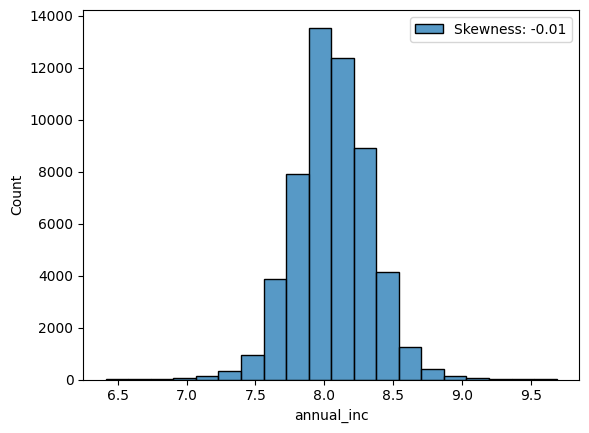

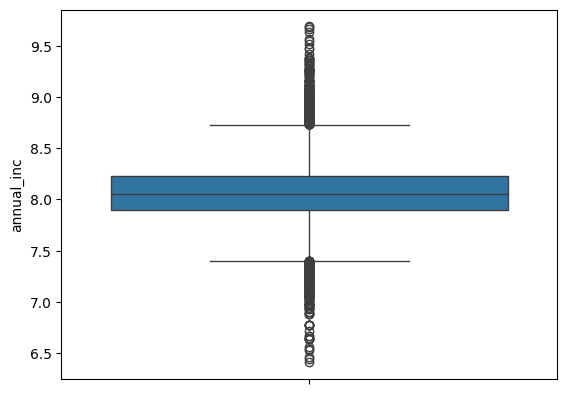

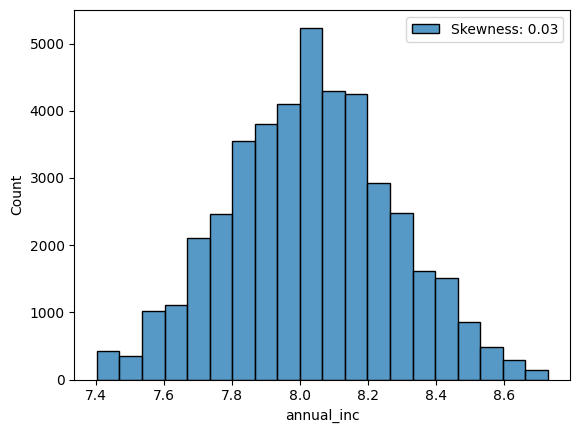

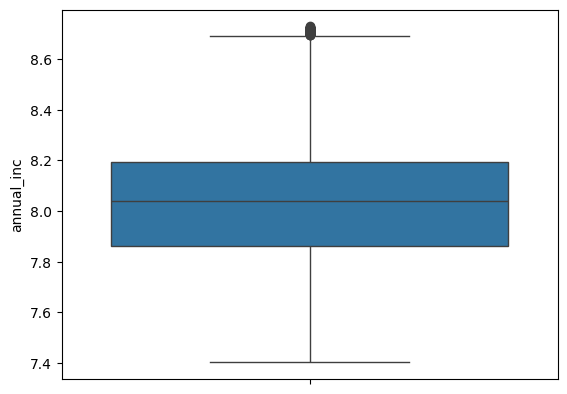

In [33]:
updated_loans_plot.hist_plot(updated_loans['annual_inc'])
updated_loans_plot.box_plot(updated_loans['annual_inc'])
loans_final = data_transform.remove_outliers(['int_rate','instalment','annual_inc', 'open_accounts',
                                                     'total_accounts','total_payment', 'total_payment_inv',
                                                     'total_rec_prncp', 'total_rec_int', 'last_payment_amount'])
updated_loans_plot.hist_plot(loans_final['annual_inc'])
updated_loans_plot.box_plot(loans_final['annual_inc'])

Compares the correlation of all numeric (integer or float) columns in the dataset to look for overly correlated columns to remove. Whiel some highly correlated (correlation above 0.9) columns were found, many had to be kept for later use in the analysis section. A correlation matrix is plotted to show these correlations - member_id and sub_grade are both dropped as they show high correlation and don't impact thr analysis at a later date.

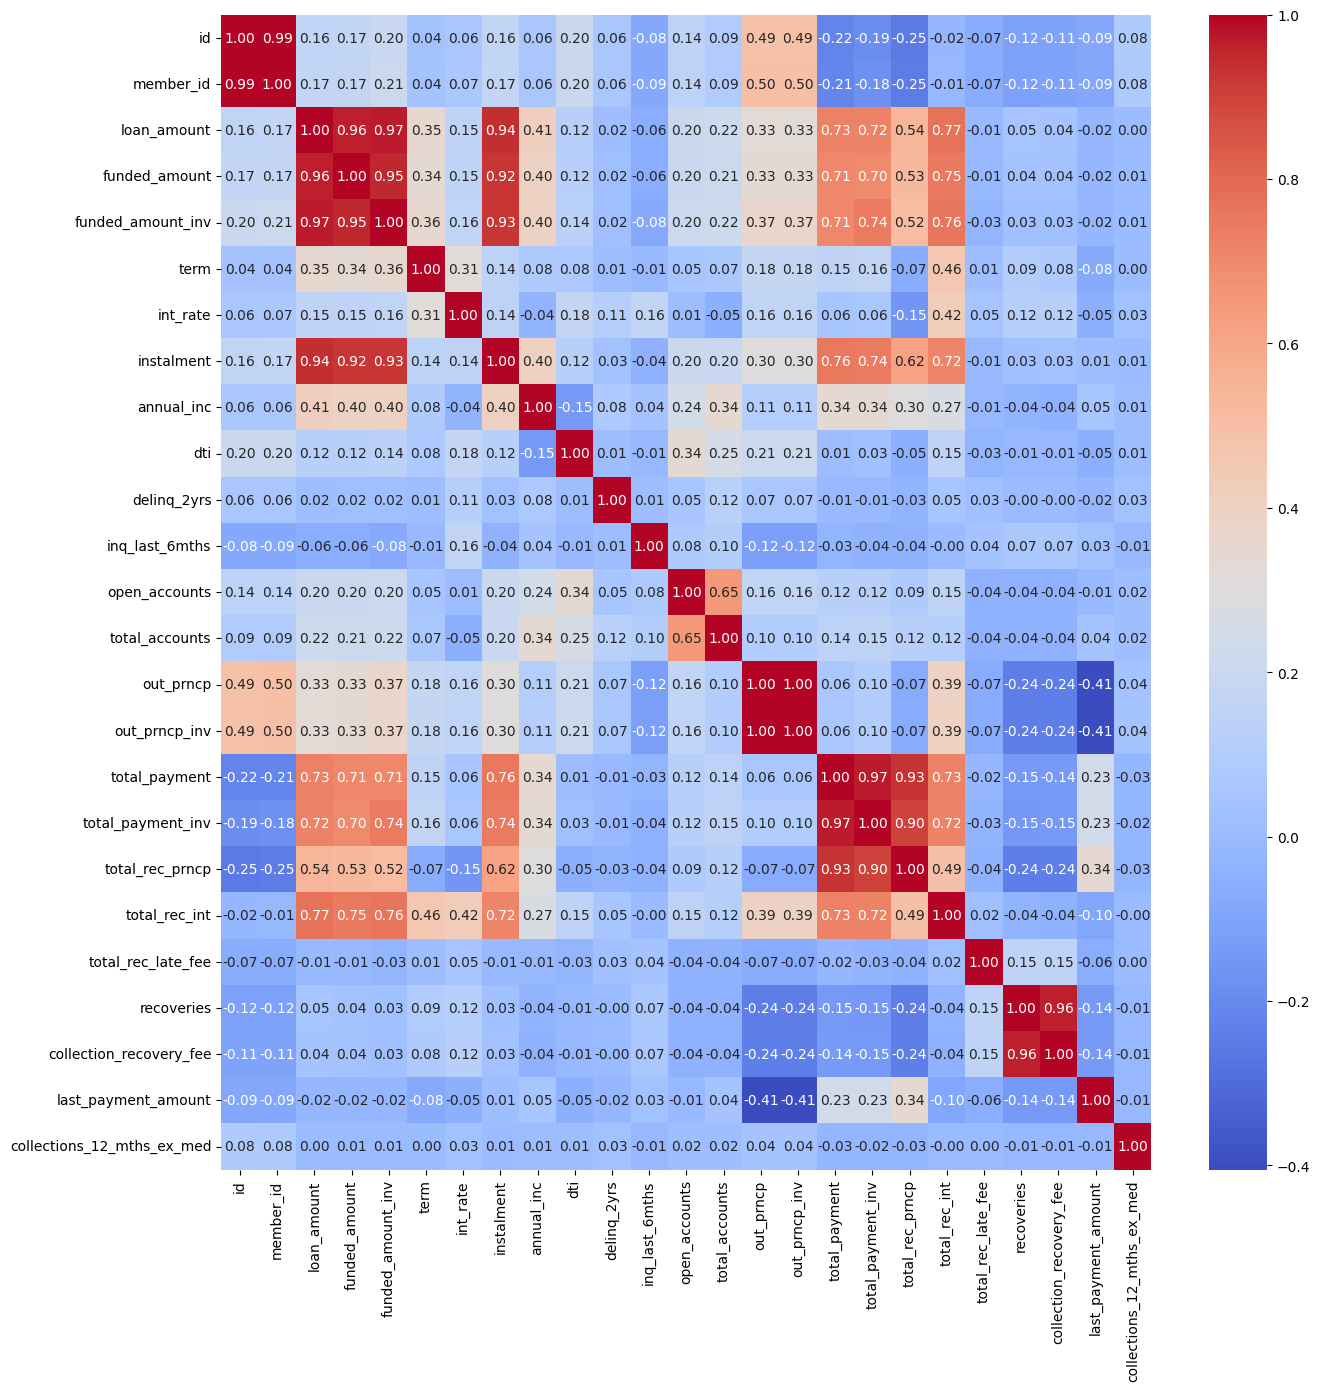

C:\Users\megan\AppData\Local\Temp\ipykernel_7892\4203233011.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans_final.drop(labels=["id", "sub_grade"], axis=1, inplace=True)


In [34]:
loans_numeric = loans_final.select_dtypes(include=['int64', 'float64'])
correlation = loans_numeric.corr()
plt.figure(figsize = (15,15))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()
loans_final.drop(labels=["id", "sub_grade"], axis=1, inplace=True)

Shows the percentage of the loans that are recovered against the investor funding and the total amount funded, both in present day and in 6 months time, as shown in the bar chart below.

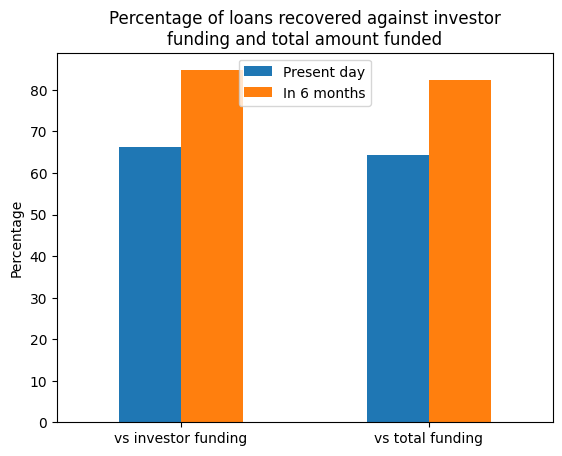

In [35]:
percent_loans = loans_final["total_rec_prncp"].sum() / loans_final["funded_amount"].sum()
percent_loans_inv = loans_final["total_rec_prncp"].sum() / loans_final["funded_amount_inv"].sum()
loans_6mths = loans_final["total_rec_prncp"] + (loans_final["instalment"]*6)
percent_loans_6mths = loans_6mths.sum() / loans_final["funded_amount"].sum()
percent_loans_inv_6mths = loans_6mths.sum() / loans_final["funded_amount_inv"].sum()

loans_state_data = {'Present day': [percent_loans_inv*100, percent_loans*100],
                    'In 6 months': [percent_loans_inv_6mths*100, percent_loans_6mths*100]}
loans_state_df = pd.DataFrame(loans_state_data, columns=['Present day', 'In 6 months'], index = ['vs investor funding', 'vs total funding'])
loans_state_title = "Percentage of loans recovered against investor funding and total amount funded"
loans_state_df.plot.bar()
plt.xticks(rotation=0, horizontalalignment="center")
plt.ylabel("Percentage")
plt.legend(loc = 'upper center')
plt.title('\n'.join(wrap(loans_state_title,50)))
plt.show()

Creates a subset of the dataset containing only loans that have been charged off. The percentage of charged off loans and the total amount that was paid towards these loans before being charged off is also shown.

In [36]:
loans_losses = loans_final[loans_final["loan_status"] == "Charged Off"]
percent_losses = len(loans_losses) / len(loans_final)
print("The percentage of charged off loans is: {0:.2f}%".format(percent_losses*100))
losses_num = loans_losses["total_rec_prncp"].sum()
print(f"The total paid towards these loans before being charged off is: £{losses_num:,.2f}")

The percentage of charged off loans is: 12.21%
The total paid towards these loans before being charged off is: £18,394,367.79


This section should calculate the total projected loss of loans from these charged off loans and then create a visulaisation of the month by month loss from start to end of these loans. However, an error has occurred where some of the remaining months of the loan are negative, which should not be possible. Currently a solution has not been found for this, so it has been left, but it doesn't impact any of the previous or later analysis.

In [37]:
loans_losses["term"] = loans_losses["term"].map({60: np.timedelta64(5,'Y'), 36: np.timedelta64(3,'Y')})
loans_losses["final_payment_date"] = loans_losses["term"] + loans_losses["issue_date"]
loans_losses["mnths_remaining"] = loans_losses["final_payment_date"].dt.to_period('M').view(dtype='int64') - loans_losses["last_payment_date"].dt.to_period('M').view(dtype='int64')
loans_losses["term"] = loans_losses["term"].map({np.timedelta64(5,'Y'): 60, np.timedelta64(3,'Y'): 36})
loans_losses["total_amount"] = loans_losses["instalment"] * loans_losses["term"]
loans_losses["total_loss"] = loans_losses["total_amount"] - loans_losses["total_rec_prncp"]
print(loans_losses["final_payment_date"], loans_losses["last_payment_date"])
print(loans_losses["mnths_remaining"].value_counts())
print(loans_losses[loans_losses["last_payment_date"]>loans_losses["final_payment_date"]])

7       2026-01-01 05:06:00
56      2026-01-01 05:06:00
83      2024-01-01 17:27:36
90      2024-01-01 17:27:36
117     2024-01-01 17:27:36
                ...        
54190   2016-08-31 17:27:36
54194   2016-07-31 17:27:36
54198   2016-07-31 17:27:36
54212   2016-06-30 17:27:36
54230   2016-06-30 17:27:36
Name: final_payment_date, Length: 5256, dtype: datetime64[ns] 7       2021-08-01
56      2021-08-01
83      2021-07-01
90      2021-07-01
117     2021-03-01
           ...    
54190   2014-05-01
54194   2015-05-01
54198   2016-02-01
54212   2015-04-01
54230   2014-03-01
Name: last_payment_date, Length: 5256, dtype: datetime64[ns]
mnths_remaining
 28    175
 23    170
 21    156
 25    154
 29    153
      ... 
-5       1
-6       1
-9       1
-2       1
-17      1
Name: count, Length: 69, dtype: int64
       member_id  loan_amount  funded_amount  funded_amount_inv  term  \
33804    1290108      24000.0        24000.0       24000.000000    36   
34293    1273377       7000.0         7

C:\Users\megan\AppData\Local\Temp\ipykernel_7892\1826281418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans_losses["term"] = loans_losses["term"].map({60: np.timedelta64(5,'Y'), 36: np.timedelta64(3,'Y')})
C:\Users\megan\AppData\Local\Temp\ipykernel_7892\1826281418.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans_losses["final_payment_date"] = loans_losses["term"] + loans_losses["issue_date"]
C:\Users\megan\AppData\Local\Temp\ipykernel_7892\1826281418.py:3: SettingWithCopyWarning: 
A valu

Another subset of the dataset was created for loans that are currently late. This calculates the percentage these loans represent as a percentage of all loans and the total number of late loans. The amount lost if these late loans were chnaged to charged off loans is also displayed, as well as the total amount of money lost to both charged off and late loans, as a percentage of all borrowed money.

In [38]:
loans_late = loans_final[(loans_final["loan_status"] == "Late (31-120 days)") | (loans_final["loan_status"] == "Late (16-30 days)")]
percent_late = len(loans_late) / len(loans_final)
print("The percentage of late loans is: {0:.2f}%".format(percent_late*100))
print("The number of late loans is:", len(loans_late))
loans_late["total_amount"] = loans_late["instalment"] * loans_late["term"]
loans_late["total_loss"] = loans_late["total_amount"] - loans_late["total_rec_prncp"]
late_num = loans_late["total_loss"].sum()
print(f"The total amount lost if these late loans were to be charged off is: £{late_num:,.2f}")
loans_final["total_amount"] = loans_final["instalment"] * loans_final["term"]
percent_late_charged_off_loss = (loans_losses["total_loss"].sum() + loans_late["total_loss"].sum()) / loans_final["total_amount"].sum()
print("The percentage lost to charged off or late loans is: {0:.2f}%".format(percent_late_charged_off_loss*100))

The percentage of late loans is: 1.41%
The number of late loans is: 608
The total amount lost if these late loans were to be charged off is: £8,782,485.32
The percentage lost to charged off or late loans is: 12.69%


C:\Users\megan\AppData\Local\Temp\ipykernel_7892\3980477055.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans_late["total_amount"] = loans_late["instalment"] * loans_late["term"]
C:\Users\megan\AppData\Local\Temp\ipykernel_7892\3980477055.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loans_late["total_loss"] = loans_late["total_amount"] - loans_late["total_rec_prncp"]
C:\Users\megan\AppData\Local\Temp\ipykernel_7892\3980477055.py:9: SettingWithCopyWarning: 
A value is trying to be set on a cop

The next lines of code investigated if there were any links between ceratin columns and people who are less likely to pay off their loan. Purpose and home_ownership were investiagted with little correlation between people that pay off their loans and those that are marked as late oir charged off. However, the grade of the loan does seem to have an effect - as shown in the graph below, both late and charged off loans have a much lower percenatge of grade A loans and a higher percenatge of lower grade D and E loans.

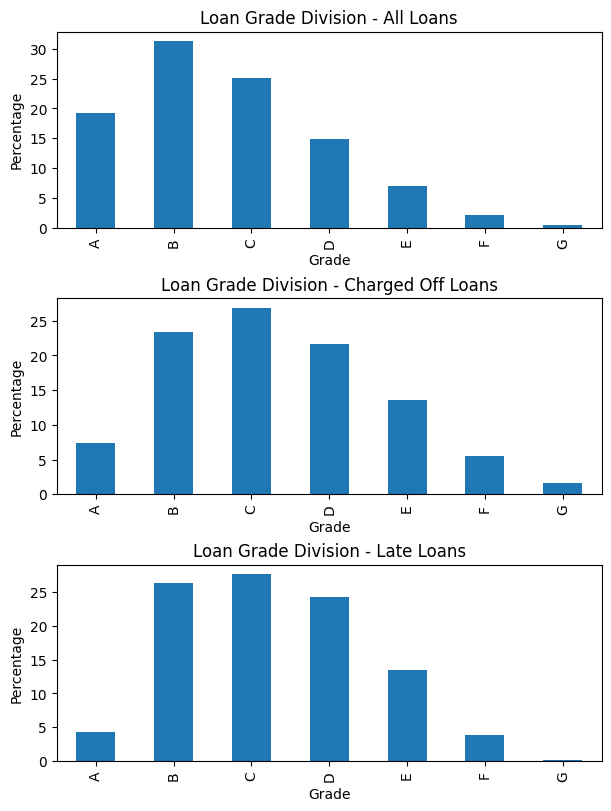

In [39]:
all_grade_percent = (loans_final.grade.value_counts().sort_index() / len(loans_final)) * 100
loss_grade_percent = (loans_losses.grade.value_counts().sort_index() / len(loans_losses)) * 100
late_grade_percent = (loans_late.grade.value_counts().sort_index() / len(loans_late)) * 100

fig, axes = plt.subplots(3, constrained_layout=True, figsize=(6, 8))
all_grade_percent.plot(kind="bar", ax=axes[0], ylabel = "Percentage", xlabel = "Grade", title = "Loan Grade Division - All Loans")
loss_grade_percent.plot(kind="bar", ax=axes[1], ylabel = "Percentage", xlabel = "Grade", title = "Loan Grade Division - Charged Off Loans")
late_grade_percent.plot(kind="bar", ax=axes[2], ylabel = "Percentage", xlabel = "Grade", title = "Loan Grade Division - Late Loans")
plt.show()